In [1]:
!pip install --quiet transformers==4.5.0
!pip install --quiet pytorch-lightning==1.2.7
!pip install sacrebleu
!pip install rouge

In [2]:
from google.colab import  drive
import os
drive.mount('/content/gdrive')

DATA_PATH = 'gdrive/Shared drives/Text_Summarization_Project/'
pickles_folder = os.listdir(DATA_PATH)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd /content/$DATA_PATH

/content/gdrive/Shared drives/Text_Summarization_Project


In [4]:
import pandas as pd
actual_df = pd.read_csv('NewsSummaryDataset.csv')
actual_df = actual_df[actual_df['density_bin'] == 'abstractive']

In [5]:
actual_df.shape

(35620, 6)

In [6]:
# %%writefile t5transformer.py
# !pip install --quiet transformers==4.5.0
# !pip install --quiet pytorch-lightning==1.2.7

import json
import pandas as pd
import numpy as np
import torch
torch.cuda.empty_cache()
# path for data
from pathlib import Path
# dataset and dataloader for functions
from torch.utils.data import Dataset, DataLoader
# lightning for data class
import pytorch_lightning as pl
# leveraging the model checkpoints
from pytorch_lightning.callbacks import ModelCheckpoint
# we can visualize performance of model
from pytorch_lightning.loggers import TensorBoardLogger
# splitting the data
from sklearn.model_selection import train_test_split
# color formatting in ANSII code for output in terminal
from termcolor import colored
# wraps the paragraph into a single line or string
import textwrap
import sacrebleu
import rouge
# installing multiple utilities
# including optimizer , tokenizer and generation module
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)
# showing bars for processes in notebook
from tqdm.auto import tqdm

# random pseudo numbers
pl.seed_everything(42) 

df = actual_df[['summary', 'text']]

# dropping out the Not Available values
df = df.dropna()
df=df.head(15000)
# using sklearn utility, splitting the data into 10:1 ratio
train_df, test_df = train_test_split(df, test_size=0.1)
train_df,valid_df = train_test_split(train_df,test_size=0.2)
# let's check the shape of our data
train_df.shape, valid_df.shape, test_df.shape 

 # class for creating the dataset which extends from pytorch 
class NewsSummaryDataset(Dataset):
   # init it , create a constructor
     def __init__(
         self,
         # data in the form of a dataframe
         data: pd.DataFrame,
         # a tokenizer
         tokenizer: T5Tokenizer,
         # max token length of input sequence
         text_max_token_len: int = 512,
         # same for the summary but less length
         summary_max_token_len: int = 128
     ):
         # saving all
         self.tokenizer = tokenizer
         self.data = data
         self.text_max_token_len = text_max_token_len
         self.summary_max_token_len = summary_max_token_len
     # length method
     def __len__(self):
         return len(self.data)
     # getting the items method  
     def __getitem__(self, index: int):
       # data row from data at current index
         data_row = self.data.iloc[index]
         # get the full text
         text = data_row['text']
         # encoding the text
         text_encoding = tokenizer(
             text,
             # setting max length
             max_length=self.text_max_token_len,
             # for same length
             padding='max_length',
             # cutting longer sequences
             truncation=True,
             # masking unwanted words
             return_attention_mask=True,
             # special tokens for start and end
             add_special_tokens=True,
             # return pytorch tensors
             return_tensors='pt'
         )
         # same is done with summary encoding
         summary_encoding = tokenizer(
             data_row['summary'],
             truncation=True,
             return_attention_mask=True,
             add_special_tokens=True,
             max_length=self.summary_max_token_len,
             padding='max_length',
             return_tensors='pt'
         )
         # creating the actual labels
         labels = summary_encoding['input_ids'] 
         labels[labels == 0] = -100 # to make sure we have correct labels for T5 text generation
         return dict(
             # data
             text=text,
             # task
             summary=data_row['summary'],
             # easy batching
             text_input_ids=text_encoding['input_ids'].flatten(),
             # masking
             text_attention_mask=text_encoding['attention_mask'].flatten(),
             # again flatten
             labels=labels.flatten(),
             labels_attention_mask=summary_encoding['attention_mask'].flatten()
         ) 

   # data module for pytorch lightning
class NewsSummaryDataModule(pl.LightningDataModule):
     def __init__(
         self,
         # pass in train data
         train_df: pd.DataFrame,
        # pass in validation data
         valid_df: pd.DataFrame,
         # pass in test data
         test_df: pd.DataFrame,
         # tokenizer
         tokenizer: T5Tokenizer,
         # batch_size
         batch_size: int = 1,
         # length of sequence
         text_max_token_len: int = 128,
         # length of output sequence
         summary_max_token_len: int = 64
     ):
         super().__init__()
         # storing the data in class objects
         self.train_df = train_df
         self.valid_df = valid_df
         self.test_df = test_df
         self.batch_size = batch_size
         self.tokenizer = tokenizer
         self.text_max_token_len = text_max_token_len
         self.summary_max_token_len = summary_max_token_len
     # automatically called by the trainer  
     def setup(self, stage=None):
         self.train_dataset = NewsSummaryDataset(
             self.train_df,
             self.tokenizer,
             self.text_max_token_len,
             self.summary_max_token_len
         )
         self.valid_dataset = NewsSummaryDataset(
             self.valid_df,
             self.tokenizer,
             self.text_max_token_len,
             self.summary_max_token_len
         )
         self.test_dataset = NewsSummaryDataset(
             self.test_df,
             self.tokenizer,
             self.text_max_token_len,
             self.summary_max_token_len
         )
     # for train data
     def train_dataloader(self):
         return DataLoader(
             self.train_dataset,
             batch_size=self.batch_size,
             shuffle=True,
             num_workers=2
         )
   # for test data
     def test_dataloader(self):
         return DataLoader(
             self.test_dataset,
             batch_size=self.batch_size,
             shuffle=True,
             num_workers=2
         )
     # valid data
     def val_dataloader(self):
         return DataLoader(
             self.valid_dataset,
             batch_size=self.batch_size,
             shuffle=True,
             num_workers=2
         ) 

# create lightning module for summarizatio
class NewsSummaryModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
        self.train_loss = []
        self.test_loss = []
        self.valid_loss = []
    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )
        return output.loss, output.logits
    def training_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']
        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )
        self.train_loss.append(loss.item())
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    def validation_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']
        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )
        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.valid_loss.append(loss.item())
        return loss
    def test_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']
        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )
        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.test_loss.append(loss.item())
        return loss
    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001) 

def summarizeText(text):
     text_encoding = tokenizer(
         text,
         max_length=512,
         padding='max_length',
         truncation=True,
         return_attention_mask=True,
         add_special_tokens=True,
         return_tensors='pt'
     )
     generated_ids = trained_model.model.generate(
         input_ids=text_encoding['input_ids'],
         attention_mask=text_encoding['attention_mask'],
         max_length=150,
         num_beams=2,
         repetition_penalty=2.5,
         length_penalty=1.0,
         early_stopping=True
     )
     preds = [
             tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
             for gen_id in generated_ids
     ]
     return "".join(preds) 

def bleu(targets, predictions):
  """Computes BLEU score.
  Args:
    targets: list of strings or list of list of strings if multiple references
      are present.
    predictions: list of strings
  Returns:
    bleu_score across all targets and predictions
  """
  if isinstance(targets[0], list):
    targets = [[x for x in target] for target in targets]
  else:
    # Need to wrap targets in another list for corpus_bleu.
    targets = [targets]

  bleu_score = sacrebleu.corpus_bleu(predictions, targets,
                                     smooth_method="exp",
                                     smooth_value=0.0,
                                     force=False,
                                     lowercase=False,
                                     tokenize="intl",
                                     use_effective_order=False)
  return {"bleu": bleu_score.score}


def compute_rouge(predictions, targets):
    predictions = [" ".join(prediction).lower() for prediction in predictions]
    predictions = [prediction if prediction else "EMPTY" for prediction in predictions]
    targets = [" ".join(target).lower() for target in targets]
    targets = [target if target else "EMPTY" for target in targets]
    rouge = rouge.Rouge()
    scores = rouge.get_scores(hyps=predictions, refs=targets, avg=True)
    return scores



Global seed set to 42


In [7]:
# leveraging the base T5 transformer
MODEL_NAME = 't5-base'
# instantiate the tokenizer
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

In [8]:
N_EPOCHS = 1
BATCH_SIZE = 3
# call the data module
data_module = NewsSummaryDataModule(train_df,valid_df, test_df, tokenizer)
model = NewsSummaryModel()

checkpoint_callback = ModelCheckpoint(
     dirpath='checkpoints',
     filename='best-checkpoint',
     save_top_k=1,
     verbose=True,
     monitor='val_loss',
     mode='min'
 )
#  logger = TensorBoardLogger("lightning_logs", name='news-summary')
trainer = pl.Trainer(
  #  logger=logger,
    checkpoint_callback=checkpoint_callback,
    max_epochs=N_EPOCHS,
    gpus=1,
    
)
 

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Checkpoint directory checkpoints exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [9]:
trainer.fit(model, data_module)
trained_model = NewsSummaryModel.load_from_checkpoint(
     trainer.checkpoint_callback.best_model_path
 )
trained_model.freeze()
print(model.train_loss)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwa

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 10799: val_loss reached 3.21764 (best 3.21764), saving model to "/content/gdrive/Shareddrives/Text_Summarization_Project/checkpoints/best-checkpoint-v46.ckpt" as top 1


[5.081650733947754, 3.551029682159424, 4.035152435302734, 4.4710917472839355, 5.5225396156311035, 3.7756459712982178, 2.864178419113159, 2.803532361984253, 5.586263656616211, 3.620924472808838, 3.447850227355957, 4.094525337219238, 3.763209581375122, 4.331738471984863, 2.8423328399658203, 3.29575514793396, 2.661487340927124, 2.931779384613037, 3.2453460693359375, 3.7384979724884033, 3.463623285293579, 3.520023822784424, 4.350063323974609, 3.9157583713531494, 4.1486968994140625, 8.771177291870117, 5.449548244476318, 3.4833693504333496, 3.4582180976867676, 2.8761842250823975, 2.964843511581421, 3.3524065017700195, 2.7353453636169434, 3.1539552211761475, 1.9282500743865967, 3.1267566680908203, 2.5032174587249756, 4.6663007736206055, 4.950636386871338, 3.5461266040802, 4.023298263549805, 3.9636001586914062, 3.360250949859619, 4.031722545623779, 4.831033706665039, 2.8265202045440674, 3.6723732948303223, 4.26970100402832, 3.2503557205200195, 2.8172922134399414, 3.351055145263672, 3.942879199

In [ ]:
train_loss = pd.Series(model.train_loss,name='train_loss')
valid_loss = pd.Series(model.valid_loss,name='valid_loss')

In [ ]:
valid_loss

0       3.822786
1       5.580462
2       3.232030
3       3.020889
4       2.069427
          ...   
2697    3.028545
2698    2.187093
2699    2.641975
2700    3.539181
2701    3.163801
Name: valid_loss, Length: 2702, dtype: float64

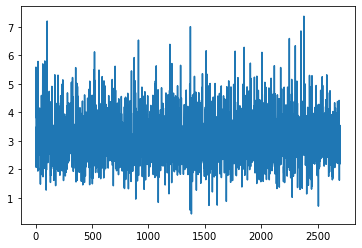

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(valid_loss)
plt.show()


In [11]:
 def compute_rouge(predictions, targets):
    # predictions = [" ".join(prediction).lower() for prediction in predictions]
    # predictions = [prediction if prediction else "EMPTY" for prediction in predictions]
    # targets = [" ".join(target).lower() for target in targets]
    # targets = [target if target else "EMPTY" for target in targets]
    rouge = Rouge()
    scores = rouge.get_scores(hyps=predictions, refs=targets, avg=True)
    return scores
 
 def summarizeText(text):
     text_encoding = tokenizer(
         text,
         max_length=512,
         padding='max_length',
         truncation=True,
         return_attention_mask=True,
         add_special_tokens=True,
         return_tensors='pt'
     )
     generated_ids = trained_model.model.generate(
         input_ids=text_encoding['input_ids'],
         attention_mask=text_encoding['attention_mask'],
         max_length=150,
         num_beams=2,
         repetition_penalty=2.5,
         length_penalty=1.0,
         early_stopping=True
     )
     preds = [
             tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
             for gen_id in generated_ids
     ]
     return "".join(preds) 

def evaluation_metrics(test):
    pass

In [12]:
test_df['pred_summary'] = [summarizeText(summ) for summ in test_df['summary']]

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


In [ ]:
sample_text = test_df.iloc[10]['text']
sample_text

In [ ]:
 sample_row = test_df.iloc[10]
 text = sample_row['text']
 model_summary = summarizeText(text)
 print(text)
 sample_row['summary']
 print("*************************************************************")



In [ ]:
%%writefile t5transformer.py


import json
import pandas as pd
import numpy as np
import torch
torch.cuda.empty_cache()
# path for data
from pathlib import Path
# dataset and dataloader for functions
from torch.utils.data import Dataset, DataLoader
# lightning for data class
import pytorch_lightning as pl
# leveraging the model checkpoints
from pytorch_lightning.callbacks import ModelCheckpoint
# we can visualize performance of model
from pytorch_lightning.loggers import TensorBoardLogger
# splitting the data
from sklearn.model_selection import train_test_split
# color formatting in ANSII code for output in terminal
from termcolor import colored
# wraps the paragraph into a single line or string
import textwrap
# installing multiple utilities
# including optimizer , tokenizer and generation module
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)
# showing bars for processes in notebook
from tqdm.auto import tqdm

# random pseudo numbers
pl.seed_everything(42) 

df = actual_df[['summary', 'text']]

# dropping out the Not Available values
df = df.dropna()
df=df.head(1500)
# using sklearn utility, splitting the data into 10:1 ratio
train_df, test_df = train_test_split(df, test_size=0.1)
train_df,valid_df = train_test_split(train_df,test_size=0.2)
# let's check the shape of our data
train_df.shape, test_df.shape 

 # class for creating the dataset which extends from pytorch 
class NewsSummaryDataset(Dataset):
   # init it , create a constructor
     def __init__(
         self,
         # data in the form of a dataframe
         data: pd.DataFrame,
         # a tokenizer
         tokenizer: T5Tokenizer,
         # max token length of input sequence
         text_max_token_len: int = 512,
         # same for the summary but less length
         summary_max_token_len: int = 128
     ):
         # saving all
         self.tokenizer = tokenizer
         self.data = data
         self.text_max_token_len = text_max_token_len
         self.summary_max_token_len = summary_max_token_len
     # length method
     def __len__(self):
         return len(self.data)
     # getting the items method  
     def __getitem__(self, index: int):
       # data row from data at current index
         data_row = self.data.iloc[index]
         # get the full text
         text = data_row['text']
         # encoding the text
         text_encoding = tokenizer(
             text,
             # setting max length
             max_length=self.text_max_token_len,
             # for same length
             padding='max_length',
             # cutting longer sequences
             truncation=True,
             # masking unwanted words
             return_attention_mask=True,
             # special tokens for start and end
             add_special_tokens=True,
             # return pytorch tensors
             return_tensors='pt'
         )
         # same is done with summary encoding
         summary_encoding = tokenizer(
             data_row['summary'],
             truncation=True,
             return_attention_mask=True,
             add_special_tokens=True,
             max_length=self.summary_max_token_len,
             padding='max_length',
             return_tensors='pt'
         )
         # creating the actual labels
         labels = summary_encoding['input_ids'] 
         labels[labels == 0] = -100 # to make sure we have correct labels for T5 text generation
         return dict(
             # data
             text=text,
             # task
             summary=data_row['summary'],
             # easy batching
             text_input_ids=text_encoding['input_ids'].flatten(),
             # masking
             text_attention_mask=text_encoding['attention_mask'].flatten(),
             # again flatten
             labels=labels.flatten(),
             labels_attention_mask=summary_encoding['attention_mask'].flatten()
         ) 

   # data module for pytorch lightning
class NewsSummaryDataModule(pl.LightningDataModule):
     def __init__(
         self,
         # pass in train data
         train_df: pd.DataFrame,
         # pass in test data
         test_df: pd.DataFrame,
         # tokenizer
         tokenizer: T5Tokenizer,
         # batch_size
         batch_size: int = 1,
         # length of sequence
         text_max_token_len: int = 128,
         # length of output sequence
         summary_max_token_len: int = 64
     ):
         super().__init__()
         # storing the data in class objects
         self.train_df = train_df
         self.test_df = test_df
         self.batch_size = batch_size
         self.tokenizer = tokenizer
         self.text_max_token_len = text_max_token_len
         self.summary_max_token_len = summary_max_token_len
     # automatically called by the trainer  
     def setup(self, stage=None):
         self.train_dataset = NewsSummaryDataset(
             self.train_df,
             self.tokenizer,
             self.text_max_token_len,
             self.summary_max_token_len
         )
         self.test_dataset = NewsSummaryDataset(
             self.test_df,
             self.tokenizer,
             self.text_max_token_len,
             self.summary_max_token_len
         )
     # for train data
     def train_dataloader(self):
         return DataLoader(
             self.train_dataset,
             batch_size=self.batch_size,
             shuffle=True,
             num_workers=2
         )
   # for test data
     def test_dataloader(self):
         return DataLoader(
             self.test_dataset,
             batch_size=self.batch_size,
             shuffle=True,
             num_workers=2
         )
     # valid data
     def val_dataloader(self):
         return DataLoader(
             self.test_dataset,
             batch_size=self.batch_size,
             shuffle=True,
             num_workers=2
         ) 

# create lightning module for summarizatio
class NewsSummaryModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )
        return output.loss, output.logits
    def training_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']
        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    def validation_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']
        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss
    def test_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']
        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss
    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001) 

def summarizeText(text):
     text_encoding = tokenizer(
         text,
         max_length=512,
         padding='max_length',
         truncation=True,
         return_attention_mask=True,
         add_special_tokens=True,
         return_tensors='pt'
     )
     generated_ids = trained_model.model.generate(
         input_ids=text_encoding['input_ids'],
         attention_mask=text_encoding['attention_mask'],
         max_length=150,
         num_beams=2,
         repetition_penalty=2.5,
         length_penalty=1.0,
         early_stopping=True
     )
     preds = [
             tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
             for gen_id in generated_ids
     ]
     return "".join(preds) 

def bleu(targets, predictions):
  """Computes BLEU score.
  Args:
    targets: list of strings or list of list of strings if multiple references
      are present.
    predictions: list of strings
  Returns:
    bleu_score across all targets and predictions
  """
  if isinstance(targets[0], list):
    targets = [[x for x in target] for target in targets]
  else:
    # Need to wrap targets in another list for corpus_bleu.
    targets = [targets]

  bleu_score = sacrebleu.corpus_bleu(predictions, targets,
                                     smooth_method="exp",
                                     smooth_value=0.0,
                                     force=False,
                                     lowercase=False,
                                     tokenize="intl",
                                     use_effective_order=False)
  return {"bleu": bleu_score.score}


def compute_rouge(predictions, targets):
    predictions = [" ".join(prediction).lower() for prediction in predictions]
    predictions = [prediction if prediction else "EMPTY" for prediction in predictions]
    targets = [" ".join(target).lower() for target in targets]
    targets = [target if target else "EMPTY" for target in targets]
    rouge = Rouge()
    scores = rouge.get_scores(hyps=predictions, refs=targets, avg=True)
    return scores

# leveraging the base T5 transformer
MODEL_NAME = 't5-base'
# instantiate the tokenizer
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

N_EPOCHS = 1
BATCH_SIZE = 3
# call the data module
data_module = NewsSummaryDataModule(train_df, test_df, tokenizer)

model = NewsSummaryModel()

checkpoint_callback = ModelCheckpoint(
     dirpath='checkpoints',
     filename='best-checkpoint',
     save_top_k=1,
     verbose=True,
     monitor='val_loss',
     mode='min'
 )
#  logger = TensorBoardLogger("lightning_logs", name='news-summary')
trainer = pl.Trainer(
  #  logger=logger,
    checkpoint_callback=checkpoint_callback,
    max_epochs=N_EPOCHS,
    gpus=1,
    
)
 